#題目: 題目：將 Kaggle Dataset SMS 文件以機器學習方式分辨是否為垃圾郵件
說明：輸入文件 spam.csv 是一個至少有兩欄 v1 和 v2 的 csv 檔，v1 註明該簡訊是 ham 還是spam，v2 是 sms 內容本身，我們在讀入後先去掉不必要的欄位內容，將欄位名稱改為 labels 和 data，再將 labels 內容改成 0/1，0 代表 ham1 代表 spam。接著將內容切割成訓練集和測試集，再用 tokenizer 做前處理，最後形成可以分析的格式。

建模分析之後我們印出訓練和測試準確度，然後以 word cloud 畫出 spam 和 ham 常用的字，再分別印出判斷錯誤的 SMS 供未來改進。

延伸：可用不同的 tokenizer，不同的 ML 分類器做改進準確率的比較。

範例程式檔名：spam_sms_ 垃圾簡訊偵測器.py，以 Naïve Bayes (MultinomialNB) 方式完成

模組：sklearn, pandas, numpy, wordcloud

輸入檔：spam.csv

成績：辨識百分率

In [2]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from wordcloud import WordCloud

# 資料來自：
# https://www.kaggle.com/uciml/sms-spam-collection-dataset

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# 刪除不必要的欄位
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# 重新命名欄位
df.columns = ['labels', 'data']

# 二元數位化標記(labels)
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

df[:6]

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1


train score: 0.993838735601393
test score: 0.9864056552474171


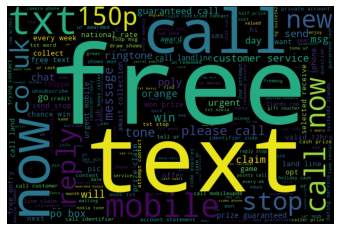

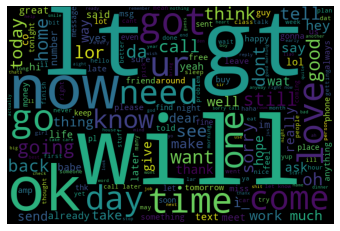


=========sneaky spam==========

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
SMS. ac Sptv: The New Jersey Devils and the Detroit Red Wings play Ice Hockey. Correct or Incorrect? End? Reply END SPTV
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
How about getting in touch with folks waiting for company? Just txt back your NAME and AGE to opt in! Enjoy the community (150p/SMS)
Filthy stories and GIRLS waiting for your
Dont forget you can place as many FREE Requests with 1stchoice.co

In [22]:
# 分為訓練與測試組
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

# 方法1:以TF-IDF 為特徵
tfidf = TfidfVectorizer(decode_error='ignore')
Xtrain = tfidf.fit_transform(df_train)
Xtest = tfidf.transform(df_test)
# 方法2:以數量為特徵
count_vectorizer = CountVectorizer(decode_error='ignore')
Xtrain = count_vectorizer.fit_transform(df_train)
Xtest = count_vectorizer.transform(df_test)



# 產生模型，訓練，印出
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))
# exit()


# 以wordcloud visualize 數據
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

visualize('spam')
visualize('ham')


# 找出判斷錯誤的地方
X = tfidf.transform(df['data'])
df['predictions'] = model.predict(X)

# 沒預測出的SPAM
# is actually spam but not detected as spam
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
print("\n=========sneaky spam==========\n")
for msg in sneaky_spam:
  print(msg)

# 以為是SPAM其實誤判
# is actually not spam but detected as spam
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
print("\n=========not actually spam==========\n")
for msg in not_actually_spam:
  print(msg)

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

tfidf = TfidfVectorizer(decode_error='ignore')
Xtrain_tfidf = tfidf.fit_transform(df_train)
Xtest_tfidf = tfidf.transform(df_test)

count_vectorizer = CountVectorizer(decode_error='ignore')
Xtrain_CV = count_vectorizer.fit_transform(df_train)
Xtest_CV = count_vectorizer.transform(df_test)

classifier_names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier()]

paired_f = zip(features, feature_impl)
paired_c = zip(classifier_names, classifiers)
paired_cc = zip(classifier_names, classifiers) #


for name_c, classifiers in paired_c:
  classifiers.fit(Xtrain_tfidf,Ytrain)
  print("Feature extraction method: TF-IDF, Classification accuracy for {}: {}".format(name_c, classifiers.score(Xtest,Ytest)))

for name_c, classifiers in paired_cc:
  classifiers.fit(Xtrain_CV,Ytrain)
  print("Feature extraction method: CountVectorizer, Classification accuracy for {}: {}".format(name_c, classifiers.score(Xtest,Ytest)))

Feature extraction method: TF-IDF, Classification accuracy for Nearest Neighbors: 0.967374
Feature extraction method: TF-IDF, Classification accuracy for Linear SVM: 0.958673
Feature extraction method: TF-IDF, Classification accuracy for RBF SVM: 0.861338
Feature extraction method: TF-IDF, Classification accuracy for Decision Tree: 0.897771
Feature extraction method: TF-IDF, Classification accuracy for Random Forest: 0.861338
Feature extraction method: TF-IDF, Classification accuracy for Neural Net: 0.934747
Feature extraction method: TF-IDF, Classification accuracy for AdaBoost: 0.938010
Feature extraction method: CountVectorizer, Classification accuracy for Nearest Neighbors: 0.926591
Feature extraction method: CountVectorizer, Classification accuracy for Linear SVM: 0.975530
Feature extraction method: CountVectorizer, Classification accuracy for RBF SVM: 0.891789
Feature extraction method: CountVectorizer, Classification accuracy for Decision Tree: 0.946166
Feature extraction method